# Convolutionnal Generative Adversarial Networks
## Initialisation and dataset preparation

First, let us import the required libraries.

In [71]:
import tensorflow as tf
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, stft, istft
import matplotlib.pyplot as plt
import librosa
import librosa.display
from misceallaneous import getWavFileAsNpArray, displaySpectrogram
from IPython.display import Audio

Then, let us include the dataset.

The dataset is made of two files: `clean/p1.wav`and `white/p1.wav` which are converted into arrays of `int32` and then split into segments of `samples_length`.

The goal of the CGAN here is to predict the clean sample, when fed with the white one.

In [72]:
samplerate = 12000
nperseg = 1024

clean = getWavFileAsNpArray("../dataset_2/clean/p1.wav")
white = getWavFileAsNpArray("../dataset_2/white/p1.wav")
clean = np.array(clean, dtype="int32")
white = np.array(white, dtype="int32")

clean_dataset = []
white_dataset = []

samples_length = nperseg

for i in range(0, clean.shape[0]-samples_length, samples_length):
    clean_dataset.append(clean[i:i+samples_length])
    white_dataset.append(white[i:i+samples_length])
clean_dataset = np.array(clean_dataset)
white_dataset = np.array(white_dataset)

In [73]:
stft_clean_dataset_real = []
stft_clean_dataset_imag = []
stft_white_dataset_real = []
stft_white_dataset_imag = []

for i in clean_dataset:
    c, t, inp = stft(i, fs=samplerate, nperseg=nperseg)
    stft_clean_dataset_real.append(np.real(inp).T)
    stft_clean_dataset_imag.append(np.imag(inp).T)
    
for i in white_dataset:
    c, t, inp = stft(i, fs=samplerate, nperseg=nperseg)
    stft_white_dataset_real.append(np.real(inp).T)
    stft_white_dataset_imag.append(np.imag(inp).T)

stft_clean_dataset_real = np.array(stft_clean_dataset_real)
stft_clean_dataset_imag = np.array(stft_clean_dataset_imag)
stft_white_dataset_real = np.array(stft_white_dataset_real)
stft_white_dataset_imag = np.array(stft_white_dataset_imag)
print(stft_clean_dataset_real.shape, stft_clean_dataset_imag.shape, stft_white_dataset_real.shape, stft_white_dataset_imag.shape)

(10659, 3, 513) (10659, 3, 513) (10659, 3, 513) (10659, 3, 513)


# CGAN Model
The main idea of a GAN model is to create two networks who play an adversarial game:
- A Generator, whose goal is to produce the most realistic samples possible to fool the Discriminator
- A Discriminator, whose goal is to correctly guess if its input is a real sample from the clean dataset or an output created by the Generator

### Discriminator

The discriminator here uses a layer to process the Short-Time Fourier Transform (https://en.wikipedia.org/wiki/Short-time_Fourier_transform) before reducing the problem dimension to one single boolean prediction layer.

In [74]:
def discriminator(input_shape):
    inputs = tf.keras.Input(shape=(input_shape[1], input_shape[2]))
    x2 = tf.keras.layers.Dense(512, activation="tanh")(inputs)
    x3 = tf.keras.layers.Dense(256, activation="tanh")(x2)
    x4 = tf.keras.layers.Dense(128, activation="tanh")(x3)
    x5 = tf.keras.layers.Dense(1, activation="tanh")(x4)
    x6 = tf.keras.layers.Flatten()(x5)
    outputs = tf.keras.layers.Dense(1, activation="tanh")(x6)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="discriminator")
    model.summary()
    model.compile(optimizer= 'adam', loss='mse', metrics=['accuracy'])
    return model

## Generator
The generator itself is a Convolutionnal Autoencoder.

Its input size and output size are both the size of the stft array.

In [75]:
def generator(sizes):
    inputs = tf.keras.Input(shape=(sizes[1], sizes[2]))
    x1 = tf.keras.layers.Dense(10, activation='tanh')(inputs)
    x4 = tf.keras.layers.Dense(sizes[2], activation='tanh')(x1)
    x5 = tf.keras.layers.Add()([inputs, x4])
    outputs = tf.keras.layers.Dense(sizes[2], activation='linear')(x4)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="autoencoder")
    model.summary()
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

Take care, the distance between the raw audio might be 'too continuous' to use a classical distance function. Maybe, use the distance function on the STFT's, or another loss function on the raw audio.

In [76]:
def evaluate_generator(g, inputs, outputs, size):
    res = 0
    s = min(size, inputs.shape[0])
    for i in range(s):
        expected = outputs[i]
        c, t, inp = stft(inputs[i], fs=samplerate, nperseg=nperseg)
        inp_real = np.real(inp)
        inp_imag = np.imag(inp)
        y = np.reshape(inp_real.T, (-1, inp_real.shape[1], inp_real.shape[0]))
        prediction = np.reshape(g.predict(y), (inp_real.shape[0], inp_real.shape[1]))
        t, y1 = istft(prediction + np.imag(inp_imag))
        res += (sum((expected-y1)**2)/expected.shape[0])
    return res/(s*10000000)

## Building the GAN

In [77]:
def get_generator_outputs(white, train_size, g, nperseg, clean):
    rng = np.random.default_rng()
    g_outputs = []
    batch = rng.choice(white, train_size)
    for i in range(train_size):
        t = np.reshape(white[i, :, :], (-1, white.shape[1], white.shape[2]))
        m = g.predict(t)
        g_outputs.append(m)
    g_outputs = np.reshape(np.array(g_outputs), (train_size,  white.shape[1], white.shape[2]))
    input_data = np.concatenate((g_outputs, clean[:train_size,]))
    output_data = np.concatenate((-1*np.ones((train_size,)), np.ones((train_size,))))
    return input_data, output_data

In [78]:
class GAN:
    def __init__(self, size, g, d):
        self.g = g
        self.d = d
        self.z = tf.keras.layers.Input(shape=(size[1],size[2]))
        self.image = self.g(self.z)
        self.valid = self.d(self.image)
        self.combined_network = tf.keras.Model(self.z, self.valid)
        self.compile()
    def block_discriminator(self):
        self.d.trainable = False
        self.g.trainable = True
        self.compile()
    def block_generator(self):
        self.g.trainable = False
        self.d.trainable = True
        self.compile()
    def compile(self):
        self.combined_network.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
        #combined_network.summary()

g = generator(stft_white_dataset_real.shape)
d = discriminator(stft_white_dataset_real.shape)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 3, 513)]          0         
_________________________________________________________________
dense_64 (Dense)             (None, 3, 10)             5140      
_________________________________________________________________
dense_65 (Dense)             (None, 3, 513)            5643      
_________________________________________________________________
dense_66 (Dense)             (None, 3, 513)            263682    
Total params: 274,465
Trainable params: 274,465
Non-trainable params: 0
_________________________________________________________________
Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 3, 513)]          0         
__________________________

In [79]:
def train_on_batch(d, i, o, verbose=True):  
    history = d.fit(i, o, batch_size=16, verbose=verbose)
    return np.mean(history.history['accuracy'])

In [80]:
train_size = 1000

Step 9
Training the discriminator
0.10700000077486038
0.12849999964237213
0.14900000393390656
0.21699999272823334
0.29600000381469727
0.351500004529953
0.3799999952316284
0.45649999380111694
0.49549999833106995
0.4975000023841858
0.4984999895095825
0.4984999895095825
0.4984999895095825
0.4984999895095825
0.4984999895095825
0.4984999895095825
0.4984999895095825
0.49900001287460327
0.4984999895095825
0.49900001287460327
0.49900001287460327
0.49900001287460327
0.49900001287460327
0.49900001287460327
0.49950000643730164
0.49900001287460327
0.49950000643730164
0.49950000643730164
0.49900001287460327
0.49950000643730164
0.49950000643730164
0.4169999957084656
0.4830000102519989
0.49900001287460327
0.5
Training the generator
0.8899999856948853
1.0
Step 9
Training the discriminator
0.4560000002384186
0.4909999966621399
0.5
Training the generator
0.7160000205039978
0.996999979019165
Step 9
Training the discriminator
0.4595000147819519
0.47749999165534973
0.4950000047683716
0.5
Training the gener

0.4715000092983246
0.49149999022483826
0.49950000643730164
0.5
Training the generator
0.06700000166893005
0.527999997138977
0.7829999923706055
0.843999981880188
0.9129999876022339
0.9440000057220459
0.968999981880188
Step 9
Training the discriminator
0.4699999988079071
0.49399998784065247
0.49799999594688416
0.5
Training the generator
0.02500000037252903
0.29499998688697815
0.7670000195503235
0.8740000128746033
0.9390000104904175
0.949999988079071
0.9589999914169312
Step 9
Training the discriminator
0.46950000524520874
0.4934999942779541
0.49950000643730164
0.5
Training the generator
0.05999999865889549
0.4740000069141388
0.7160000205039978
0.8270000219345093
0.8849999904632568
0.925000011920929
0.949999988079071
0.9520000219345093
Step 9
Training the discriminator
0.47999998927116394
0.4975000023841858
0.49950000643730164
0.5
Training the generator
0.04800000041723251
0.4909999966621399
0.746999979019165
0.8190000057220459
0.8659999966621399
0.8700000047683716
0.8960000276565552
0.916

0.46650001406669617
0.4984999895095825
0.5
Training the generator
0.007000000216066837
0.035999998450279236
0.1379999965429306
0.4350000023841858
0.6809999942779541
0.8519999980926514
0.8920000195503235
0.9279999732971191
0.9440000057220459
0.9399999976158142
0.9599999785423279
Step 9
Training the discriminator
0.4645000100135803
0.49300000071525574
0.49950000643730164
0.49950000643730164
0.5
Training the generator
0.00800000037997961
0.04100000113248825
0.14100000262260437
0.41600000858306885
0.656000018119812
0.7739999890327454
0.8450000286102295
0.8709999918937683
0.8790000081062317
0.8930000066757202
0.9229999780654907
0.9390000104904175
0.9599999785423279
Step 9
Training the discriminator
0.45899999141693115
0.48899999260902405
0.4975000023841858
0.49900001287460327
0.5
Training the generator
0.0
0.02800000086426735
0.07000000029802322
0.13699999451637268
0.20800000429153442
0.3199999928474426
0.47099998593330383
0.6430000066757202
0.7409999966621399
0.8349999785423279
0.879999995

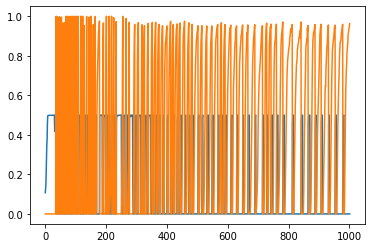

In [81]:
gan = GAN(stft_white_dataset_real.shape, g, d)
disc_acc = []
gen_acc = []
epochs = 1000
e = 0
while e < epochs:
    g_accuracy = 0
    d_accuracy = 0
    print("Step", step)
    if d_accuracy < 1:
        i, o = get_generator_outputs(stft_white_dataset_real, train_size, gan.g, nperseg, stft_clean_dataset_real)
    gan.block_generator()
    print("Training the discriminator")
    while d_accuracy < 0.5:
        e += 1
        d_accuracy = train_on_batch(gan.d, i, o, verbose=False)
        print(d_accuracy)
        disc_acc.append(d_accuracy)
        gen_acc.append(0)
    gan.block_discriminator()
    print("Training the generator")
    while  (g_accuracy <= 0.95 or g_accuracy <= d_accuracy) and g_accuracy < 1:
        e += 1
        g_accuracy = train_on_batch(gan.combined_network, stft_white_dataset_real[:train_size,], np.ones(train_size), verbose=False)
        print(g_accuracy)
        gen_acc.append(g_accuracy)
        disc_acc.append(0)
plt.plot(disc_acc)
plt.plot(gen_acc)
plt.show()

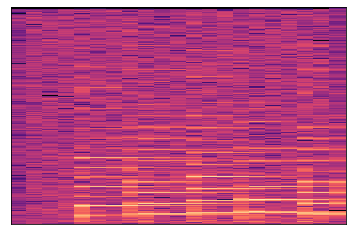

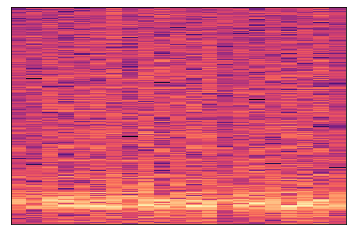

In [82]:
inputs = []
outputs = []
for i in range(10):
    x = np.reshape(white_dataset[i, :].T, (1, white_dataset.shape[1]))
    y = np.reshape(stft_white_dataset_real[i, :, :], (-1, stft_white_dataset_real.shape[1], stft_white_dataset_real.shape[2]))
    t, y1 = istft(np.reshape(gan.g.predict(y).T, (513, 3))+np.imag(stft_white_dataset_imag[i]).T)
    x2 = np.reshape(x.T, (clean_dataset.shape[1],))
    y2 = np.reshape(y1.T, (clean_dataset.shape[1],))
    inputs.append(x2)
    outputs.append(y2)

a = np.concatenate(inputs)
b = np.concatenate(outputs)

c, t, axx = stft(a, fs=samplerate, nperseg=nperseg)
c, t, bxx = stft(b, fs=samplerate, nperseg=nperseg)
displaySpectrogram(axx)
plt.show()
displaySpectrogram(bxx)
plt.show()

In [83]:
Audio(a, rate=samplerate)

In [84]:
Audio(b, rate=samplerate)